## Ross Koval
## EECS 6893: Big Data Analytics
## Final Project
## December 17th, 2021

## References

https://huggingface.co/transformers/training.html#fine-tuning-with-keras

https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/jupyter/transformers/HuggingFace%20in%20Spark%20NLP%20-%20BertForSequenceClassification.ipynb


## Transfer Learning by Finetuning Pre-trained BERT models

I will utilize the state-of-the-art BERT models, which have been pretrained on a corpus of text from both Wikipedia and Online Books, and need to be fine-tuned for domain and task specific objectives by adding a final layer for classification.

I will use the HuggingFace library to download the transformer model and encoder, and the TensorFlow deep learning framework for training.

In [1]:
! pip install transformers

     |████████████████████████████████| 3.1 MB 6.8 MB/s 
     |████████████████████████████████| 59 kB 6.0 MB/s 
     |████████████████████████████████| 895 kB 53.8 MB/s 
     |████████████████████████████████| 3.3 MB 49.2 MB/s 
     |████████████████████████████████| 596 kB 52.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


We will use the small base uncased version of the BERT model as we do not think that case-sensivity will be required for this dataset and the smaller base model should be more than sufficient in terms of model complexity for this dataset. 

In [2]:
from transformers import TFBertForSequenceClassification, BertTokenizerFast, BertTokenizer
from transformers import TFBertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertTokenizerFast

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [3]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = "/content/drive/MyDrive/Columbia/EECS-6893/Project/"

Mounted at /content/drive


In [4]:
import pandas as pd

path_name = root_dir + 'sentiment140.csv'
df = pd.read_csv(path_name)

In [5]:
import re 

df = df.iloc[0:120000, :]

def clean_text(text):
    text = text.lower().strip("b'").strip('b"')
    text = text.replace("'", "")
    text = re.sub('@(\w+)', '', text)
    text = re.sub('\W+', ' ', text)
    text = re.sub('<[^<]+?>', ' ', text)
    text = re.sub('[^A-Za-z0-9\.\!\;\:\,\?]+', ' ', text)
    text = text.replace('amp', 'and').strip()
    return text

df['CleanText'] = df['Text'].map(clean_text)
df.loc[df['Label'] == 0, 'Label'] = 0
df.loc[df['Label'] == 4, 'Label'] = 1
df['TextLength'] = df['CleanText'].map(lambda x: len(x.split(' ')))
df = df[ (df['TextLength'] >= 3) <= (df['TextLength'] <= 50) ]
df.head(10)

,Unnamed: 0,Text,Label,CleanText,TextLength
0,0,"b""i'm 10x cooler than all of you! """,1,im 10x cooler than all of you,7
1,1,b'O.kk? Thats weird I cant stop following peop...,0,o kk thats weird i cant stop following people ...,18
2,2,b'what a beautiful day not to got to my first ...,1,what a beautiful day not to got to my first class,11
3,3,"b"".@HildyGottlieb &amp; I was just saying to M...",1,and i was just saying to mahaal yesterday ever...,22
4,4,b'kinda sad and confused why do guys do this?',0,kinda sad and confused why do guys do this,9
5,5,b'@Real_DavidCook YES &amp; YES ',1,yes and yes,3
6,6,"b""@GDGOfficial But it's another beautiful day ...",1,but its another beautiful day here in europe y...,21
7,7,b'Working through hundreds of assignments ',0,working through hundreds of assignments,5
8,8,b'driving with the moonroof and windows open i...,0,driving with the moonroof and windows open is ...,23
9,9,"b""@scott_mills Gutted! I worked for the fringe...",0,gutted i worked for the fringe last year wont ...,13


In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=123)

In [7]:
train_examples = train['CleanText'].tolist()
train_y = train['Label'].values
test_examples = test['CleanText'].tolist()
test_y = test['Label'].values

In this iteration, we will freeze the weights on all layers but the final classification layer so as to preserve the underlying language representation of the BERT model. 

In [8]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [9]:
train_encodings = tokenizer(train_examples, truncation=True, padding=True)
test_encodings = tokenizer(test_examples, truncation=True, padding=True)

In [10]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings),train_y.reshape((-1,1))))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_y.reshape((-1,1))))

In [11]:
train_dataset = train_dataset.batch(64).cache().prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(64).cache().prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=tf.metrics.SparseCategoricalAccuracy())
print(model.summary())
history = model.fit(train_dataset, validation_data=test_dataset, epochs=5, batch_size=64)

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1499/1499 [==============================] - 1609s 1s/step - loss: 0.4162 - sparse_categorical_accuracy: 0.8091 - val_loss: 0.3852 - val_sparse_categorical_accuracy: 0.8330
Epoch 2/5
1499/1499 [==============================] - 1587s 1s/step - loss: 0.3383 - sparse_

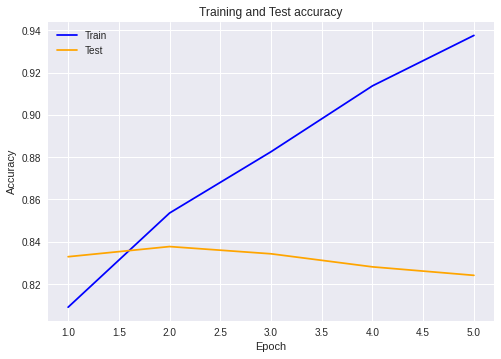

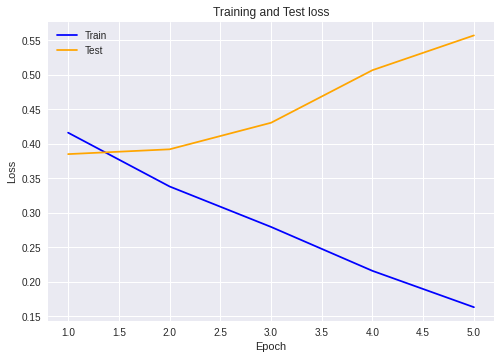

In [16]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

def plot(history):

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.title('Training and Test accuracy')
    plt.plot(epochs, acc, color='blue', label='Train')
    plt.plot(epochs, val_acc, color='orange', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.figure()
    plt.title('Training and Test loss')
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plot(history)

In [15]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

375/375 [==============================] - 106s 282ms/step - loss: 0.5573 - sparse_categorical_accuracy: 0.8242
Test Loss: 0.5572813153266907
Test Accuracy: 0.8241524696350098


## Convert model and save with metadata for support in Spark NLP 

In [ ]:
MODEL_NAME = 'BERT_TEST_EPOCH_5'
tokenizer.save_pretrained(root_dir + './{}_tokenizer/'.format(MODEL_NAME))
model.save_pretrained(root_dir + "./{}".format(MODEL_NAME), saved_model=True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Columbia/EECS-6893/Project/./BERT_TEST_EPOCH_5/saved_model/1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Columbia/EECS-6893/Project/./BERT_TEST_EPOCH_5/saved_model/1/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
asset_path = root_dir + '{}/saved_model/1/assets'.format(MODEL_NAME)

!cp {root_dir}{MODEL_NAME}_tokenizer/vocab.txt {asset_path}

In [ ]:
labels = model.config.label2id
labels = sorted(labels, key=labels.get)

with open(asset_path + '/labels.txt', 'w') as f:
    f.write('\n'.join(labels))

## Load as Spark NLP model for Sequence Classification 

In [ ]:
from sparknlp.annotator import *

MODEL_NAME = 'BERT_TEST_EPOCH_5'

model = BertForSequenceClassification.loadSavedModel(
     root_dir + '{}/saved_model/1'.format(MODEL_NAME),
     spark
 )\
  .setInputCols(["document",'token'])\
  .setOutputCol("PredLabel")

model.write().overwrite().save(root_dir + "/{}_spark_nlp".format(MODEL_NAME))